In [73]:
%reload_ext autoreload
%autoreload 2

import argparse
import os
import time
import json
import uuid
import warnings
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import wandb
import pandas as pd
from sklearn.metrics import r2_score

import sys
sys.path.append('model/')
sys.path.append('../SETPOINT/')

from model import NORMADecoder, NormaLight
from loss import *
from utils import *
from data import *
from evaluate import *

inv_vocab = {v: k for k, v in TEST_VOCAB.items()}

import warnings
warnings.filterwarnings('ignore')


In [65]:
def get_counterfactual_predictions(checkpoint_id, sequences, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    checkpoint_path = f'model/logs/{checkpoint_id}/checkpoint_best.pth'
    checkpoint = torch.load(checkpoint_path, map_location=device)
    hyperparams = checkpoint.get('hyperparameters', {})

    model = NormaLight(
        d_model=hyperparams['d_model'],
        nhead=hyperparams['nhead'], 
        num_layers=hyperparams['num_layers'],
        num_lab_codes=len(TEST_VOCAB)
    )

    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval() 

    print(f"Loaded checkpoint for run ID: {checkpoint.get('run_id', 'unknown')}")
    print(f"Hyperparameters: {hyperparams}")
    print(f"Model moved to device: {device}")

    results = []
    with torch.no_grad():
        for seq in sequences:
            hist_x = torch.from_numpy(seq['x'][:-1]).float().unsqueeze(0).unsqueeze(-1).to(device)
            hist_s = torch.from_numpy(seq['s'][:-1]).long().unsqueeze(0).to(device)
            hist_t = torch.from_numpy(seq['t'][:-1]).float().unsqueeze(0).unsqueeze(-1).to(device)
            
            sex = torch.tensor([[seq['sex']]], dtype=torch.long).to(device)
            lab = torch.tensor([[seq['cid']]], dtype=torch.long).to(device)
            next_t = torch.from_numpy(seq['t'][-1:]).float().unsqueeze(0).to(device)
            
            for next_s in [0, 1]:
                next_s = torch.tensor([[next_s]], dtype=torch.long).to(device)
                mean, logvar = model(hist_x, hist_s, hist_t, sex, lab, next_s, next_t)
                std = torch.exp(0.5 * logvar)
                
                results.append({
                    'subject_id': seq['subject_id'],
                    'cid': seq['cid'],
                    'code': inv_vocab[seq['cid']], 
                    'pred_state': 'normal' if next_s[0,0] == 1 else 'abnormal',
                    'pred_mean': mean.cpu().numpy()[0,0],
                    'pred_std': std.cpu().numpy()[0,0],
                    'true_value': seq['x'][-1],
                    'true_state': seq['s'][-1],
                })

    # Convert to dataframe
    df = pd.DataFrame(results)
    return df


In [ ]:
# checkpoint_id = 'db1efe13'
# train_seq, val_seq, test_seq = load_and_split_data()
train_counterfactual_sequences = get_counterfactual_predictions(checkpoint_id, train_seq)
val_counterfactual_sequences = get_counterfactual_predictions(checkpoint_id, val_seq)
test_counterfactual_sequences = get_counterfactual_predictions(checkpoint_id, test_seq)

all_counterfactual_sequences = pd.concat([train_counterfactual_sequences, val_counterfactual_sequences, test_counterfactual_sequences])
all_counterfactual_sequences.to_csv(f'../model/predictions/{model_name}/counterfactuals_predictions_{model_name}.csv', index=False)

Loaded checkpoint for run ID: db1efe13
Hyperparameters: {'data_path': '../../SETPOINT/data/processed/lab_measurements.csv', 'min_points': 3, 'num_patients': None, 'model_type': 'NormaLight', 'loss_type': 'GaussianNLLLoss', 'd_model': 64, 'nhead': 2, 'num_layers': 2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'grad_clip': 1.0, 'lambda_align': 0.01, 'patience': 10, 'log_dir': './logs', 'resume': False, 'wandb_project': 'norma-training', 'wandb_name': None, 'seed': 42}
Model moved to device: cuda


x  \
0  [17.0, 17.9, 18.5, 17.5, 18.3, 18.2, 22.4, 21....   
1  [17.0, 17.9, 18.5, 17.5, 18.3, 18.2, 22.4, 21....   
2                     [4.21, 3.74, 3.93, 3.67, 4.27]   
3                     [4.21, 3.74, 3.93, 3.67, 4.27]   
4          [5.3, 5.2, 8.6, 5.1, 5.2, 10.8, 6.8, 4.3]   

                                                   t  \
0  [0.0, 3.8138888, 4.360417, 4.4666667, 5.343055...   
1  [0.0, 3.8138888, 4.360417, 4.4666667, 5.343055...   
2    [0.0, 259.64722, 259.64722, 366.5486, 972.4097]   
3    [0.0, 259.64722, 259.64722, 366.5486, 972.4097]   
4  [0.0, 502.18958, 874.1618, 1418.9667, 2247.95,...   

                                   s  sex  cid  ref_mu     ref_var  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]    0   23  [11.5]    [0.5625]   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]    0   23  [11.5]    [0.5625]   
2                    [1, 0, 0, 0, 1]    1    6   [4.6]      [0.09]   
3                    [1, 0, 0, 0, 1]    1    6   [4.6]      [0.09]   
4           [1, 1, 1, 1, 1, 1, 1, 0]    0    8  [7.75]  [2.640625]   

   subject_id code pred_state  pred_mean  pred_std  true_value  true_state  
0   115971529   PT   abnormal  19.975594  3.718359   30.799999           0  
1   115971529   PT     normal  13.768448  0.860490   30.799999           0  
2   115971392  RBC   abnormal   3.549811  0.518895    4.270000           1  
3   115971392  RBC     normal   4.150379  0.324680    4.270000           1  
4   115971196  WBC   abnormal  12.937955  5.291152    4.300000           0

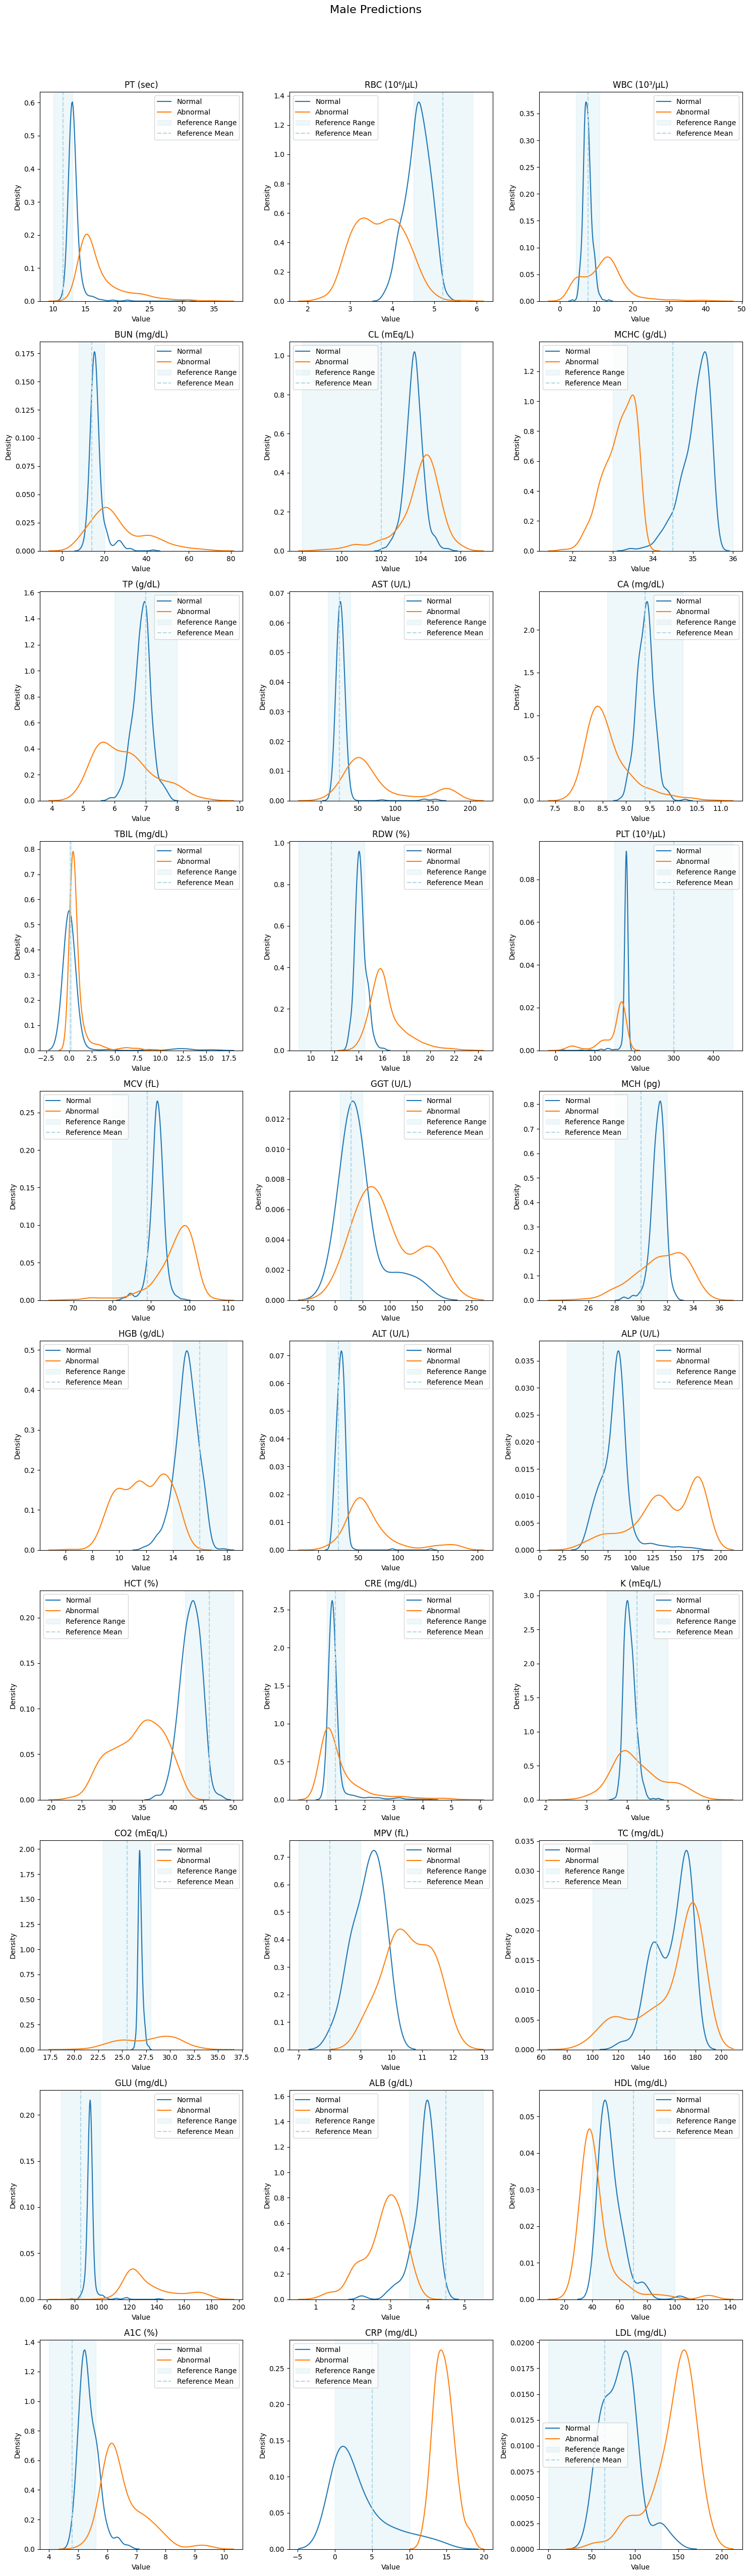

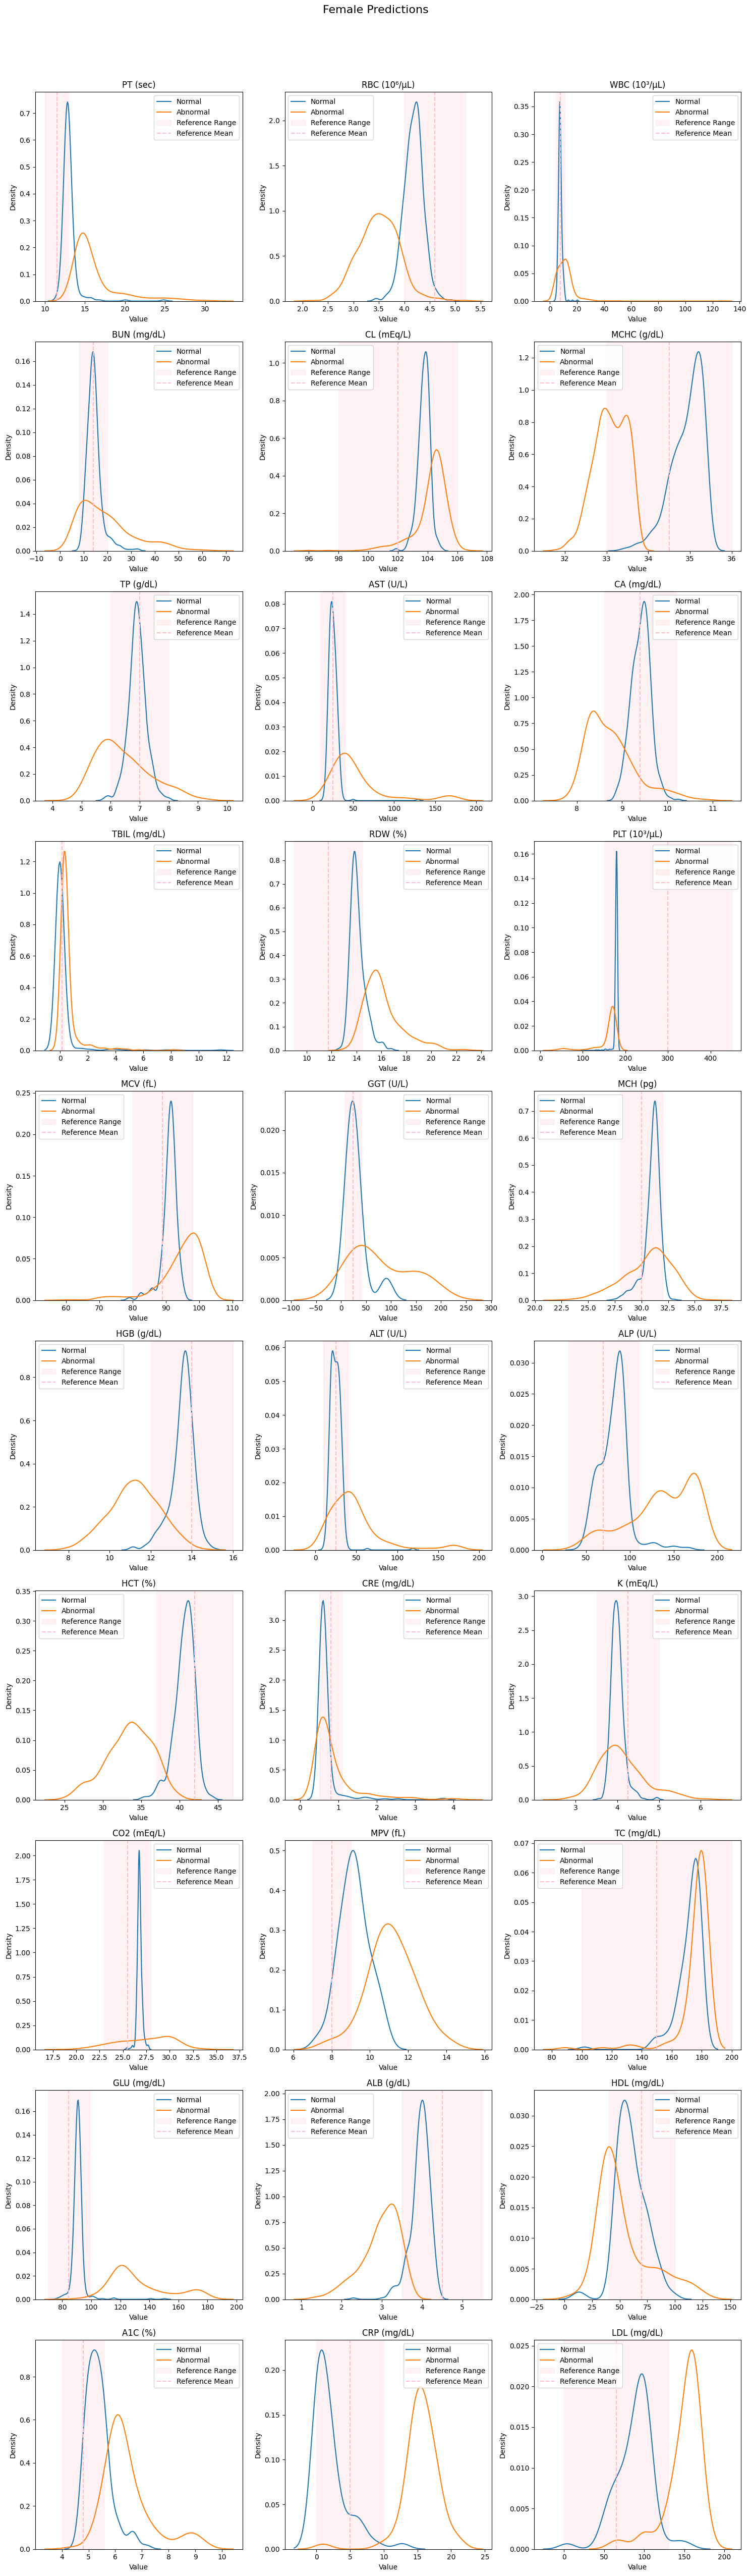

In [ ]:
# Plot distributions of predictions and reference intervals
import seaborn as sns
import matplotlib.pyplot as plt

test_df = pd.DataFrame(test_seq).merge(test_counterfactual_sequences, on=['subject_id', 'cid'])
test_df.head()
unique_codes = test_df['code'].unique()

# Create separate figures for male and female
for sex_val, sex_label in [(0, 'Male'), (1, 'Female')]:
    # Create subplots for each code
    n_codes = len(unique_codes)
    n_cols = 3
    n_rows = (n_codes + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle(f'{sex_label} Predictions', fontsize=16, y=1.02)
    axes = axes.flatten()

    for i, code in enumerate(unique_codes):
        ax = axes[i]
        # Filter data for current sex and code
        code_data = test_df[(test_df['code'] == code) & (test_df['sex'] == sex_val)]
        
        # Plot distributions for normal and abnormal predictions
        sns.kdeplot(data=code_data[code_data['pred_state']=='normal'],
                    x='pred_mean', label='Normal', ax=ax)
        sns.kdeplot(data=code_data[code_data['pred_state']=='abnormal'], 
                    x='pred_mean', label='Abnormal', ax=ax)
        
        # Get reference interval
        sex_key = 'F' if sex_val == 1 else 'M'
        low, high, unit = REFERENCE_INTERVALS[code][sex_key]
        
        # Plot reference interval range
        color = 'pink' if sex_val == 1 else 'lightblue'
        ax.axvspan(low, high, alpha=0.2, color=color, label='Reference Range')
        ax.axvline(x=(low + high)/2, color=color, linestyle='--',
                   label='Reference Mean')
    
        ax.set_title(f'{code} ({unit})')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend()

    # Remove empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

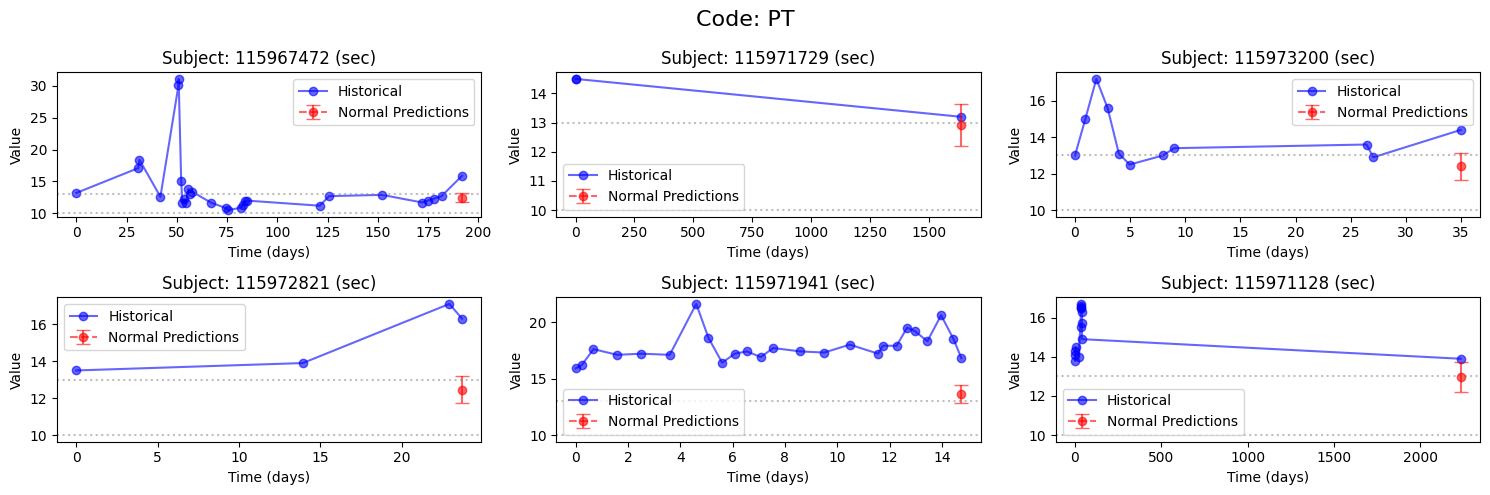

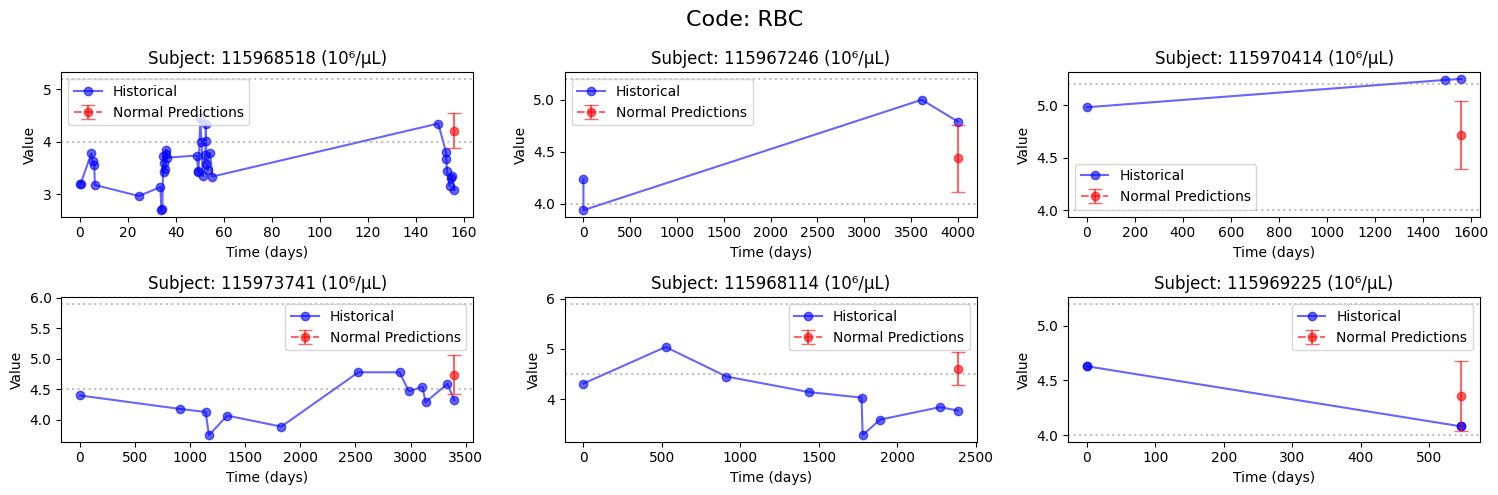

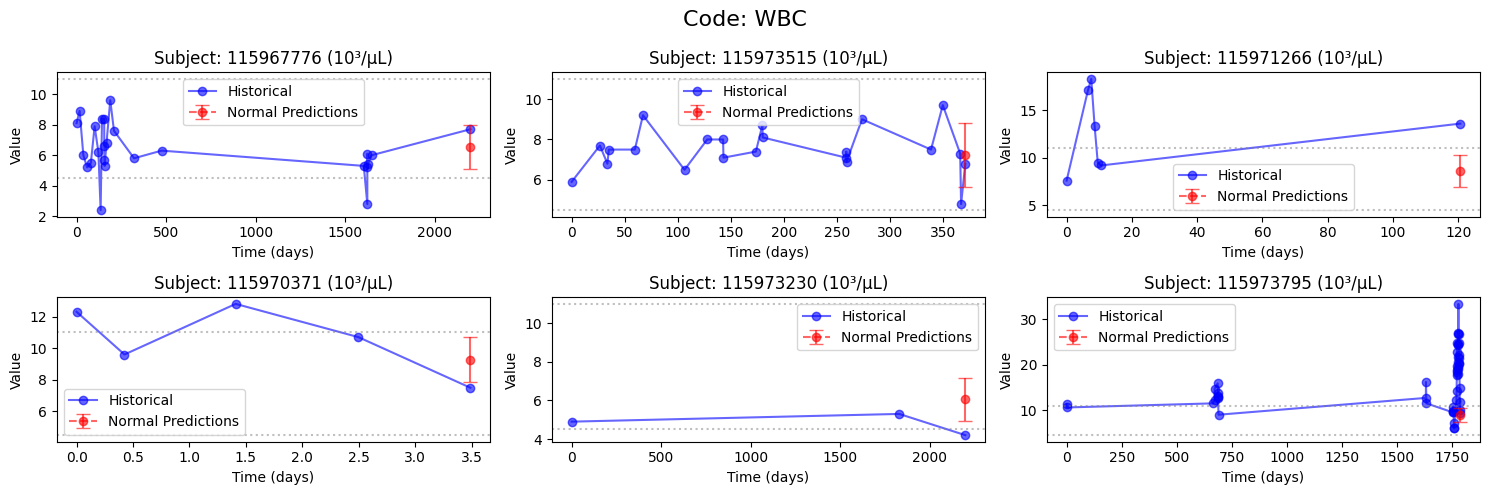

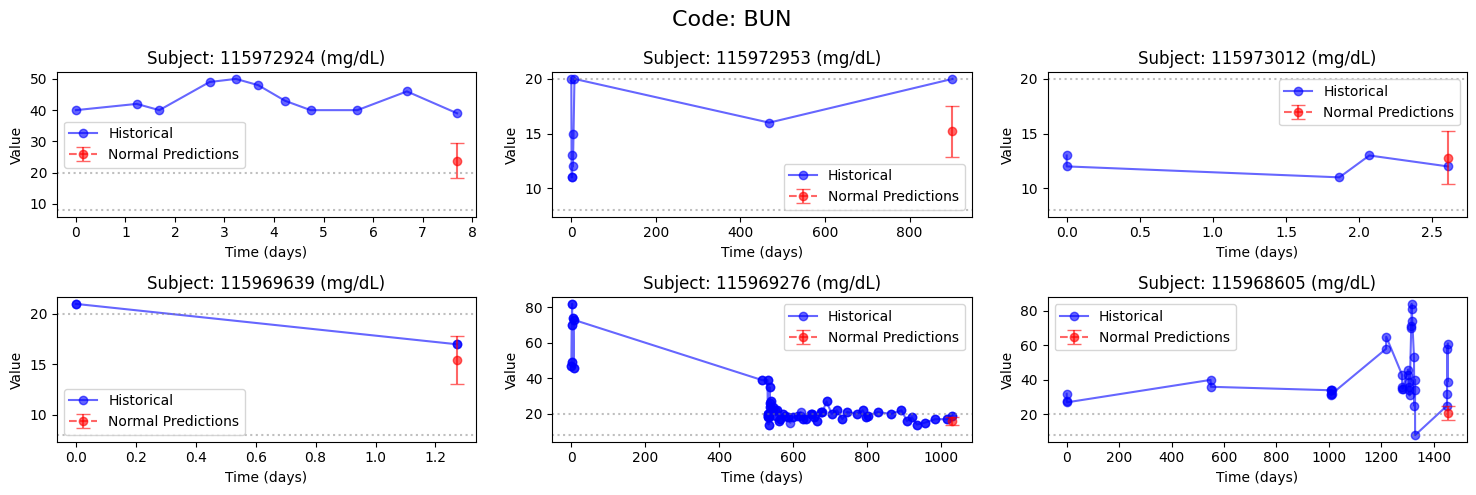

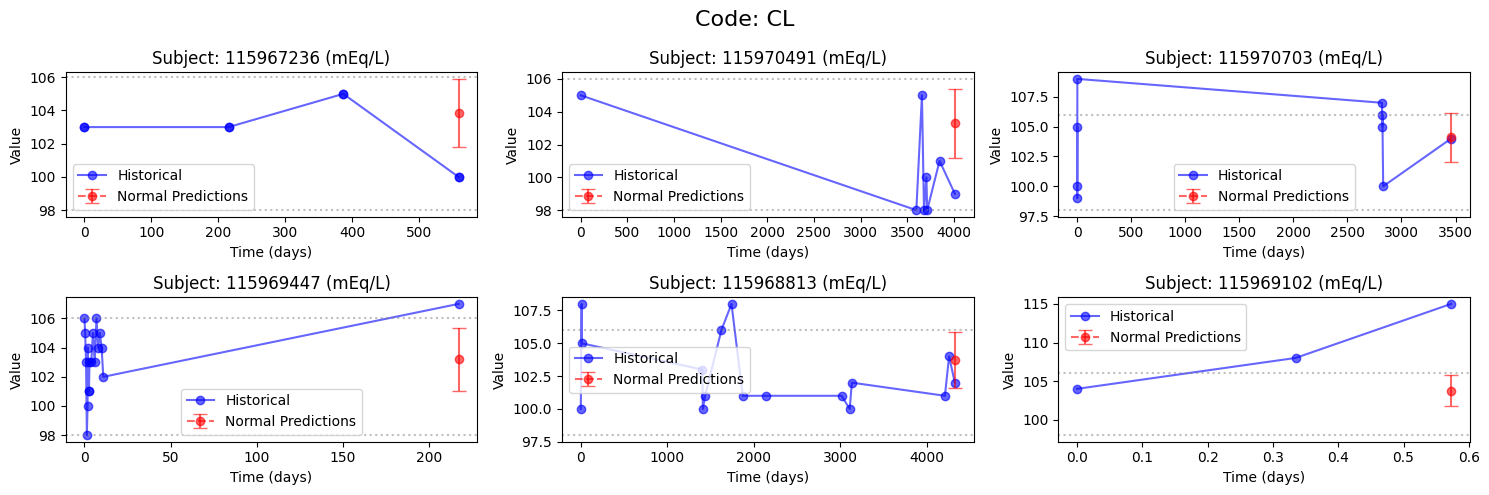

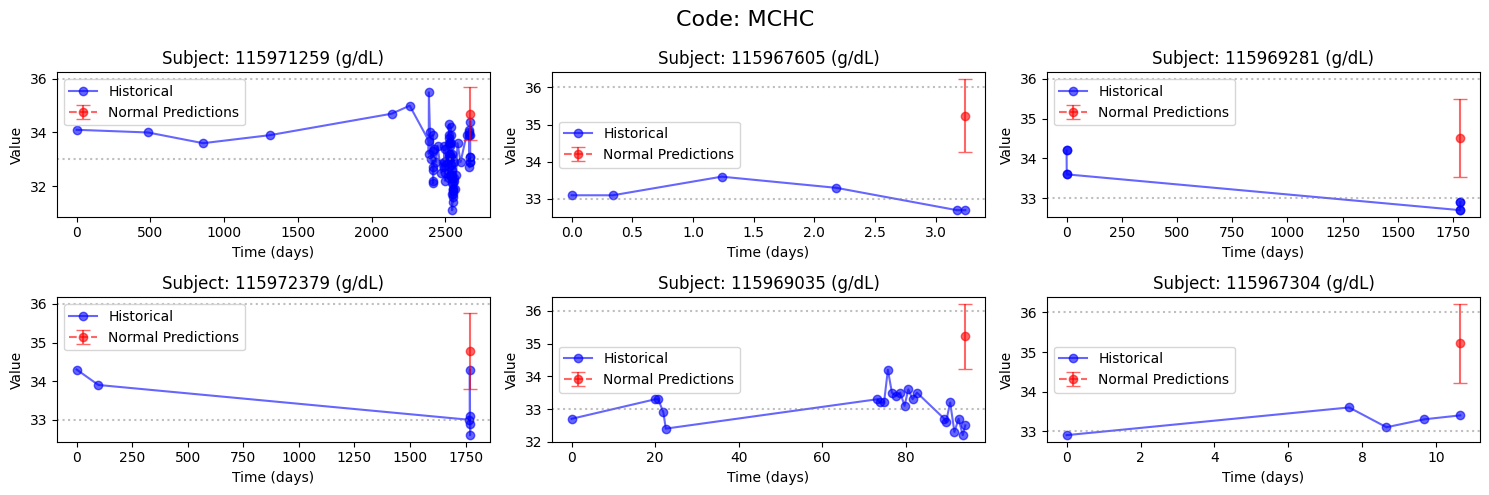

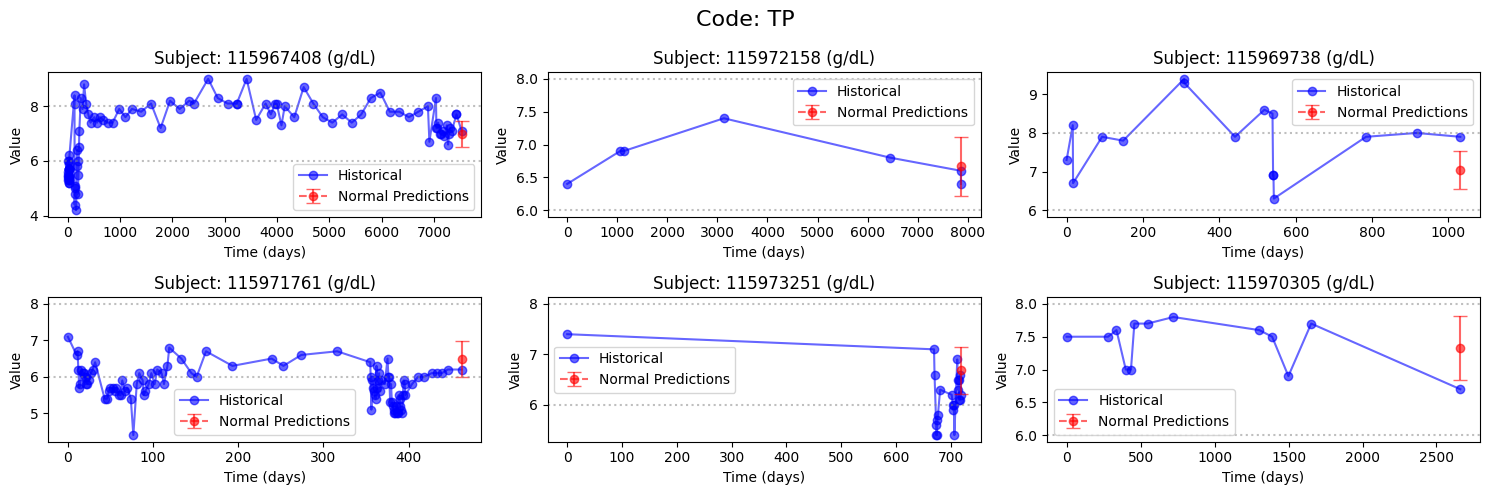

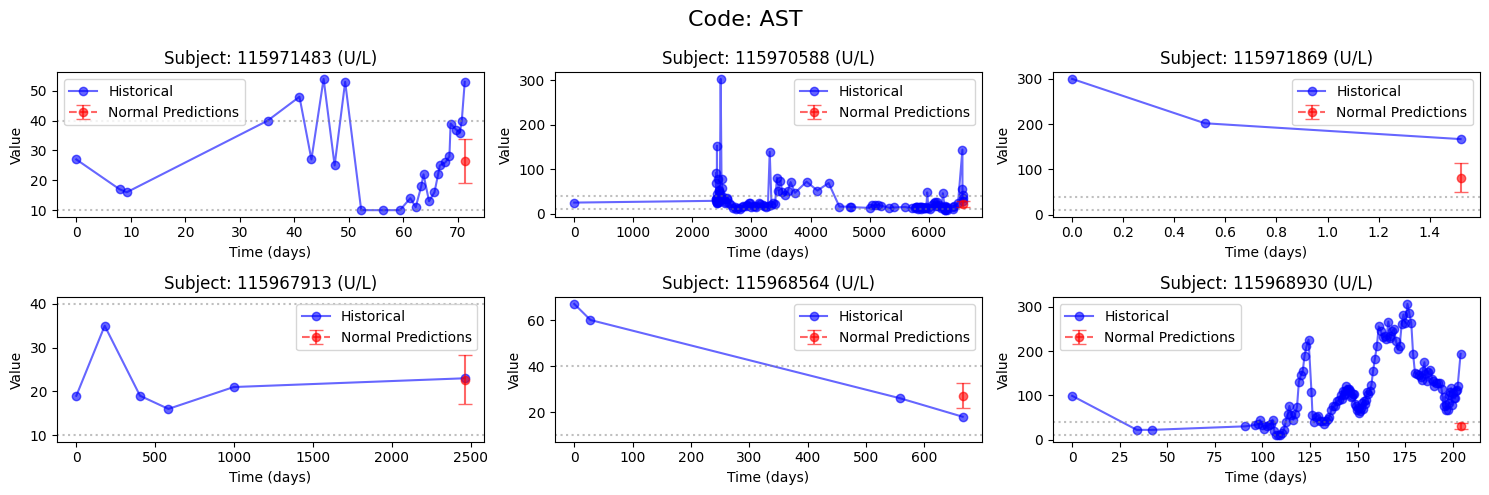

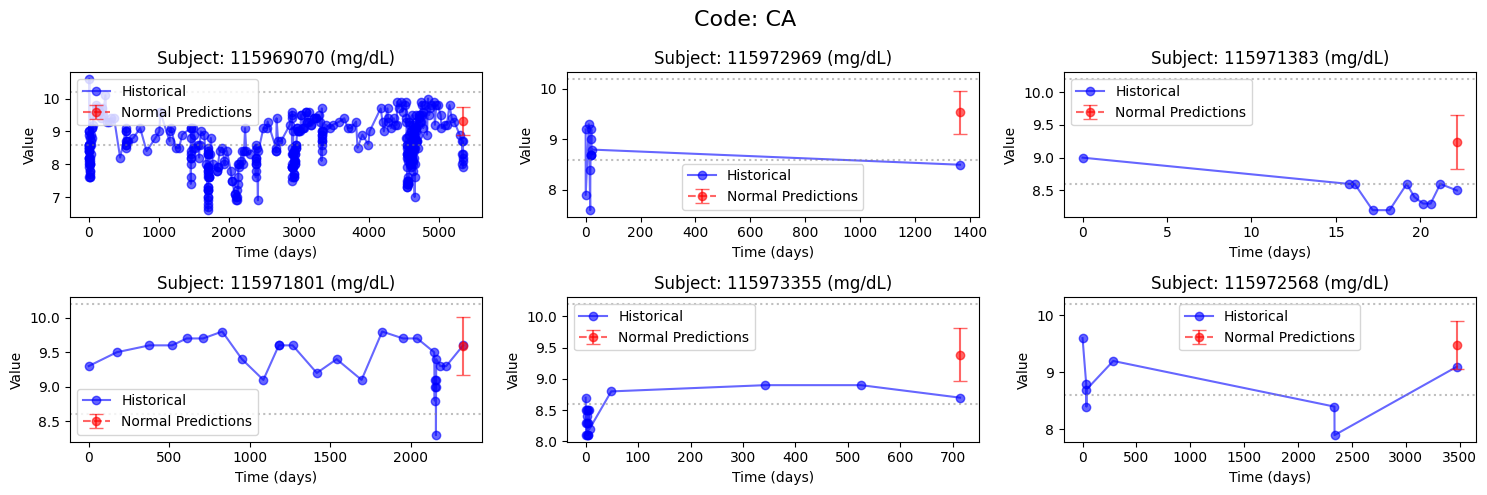

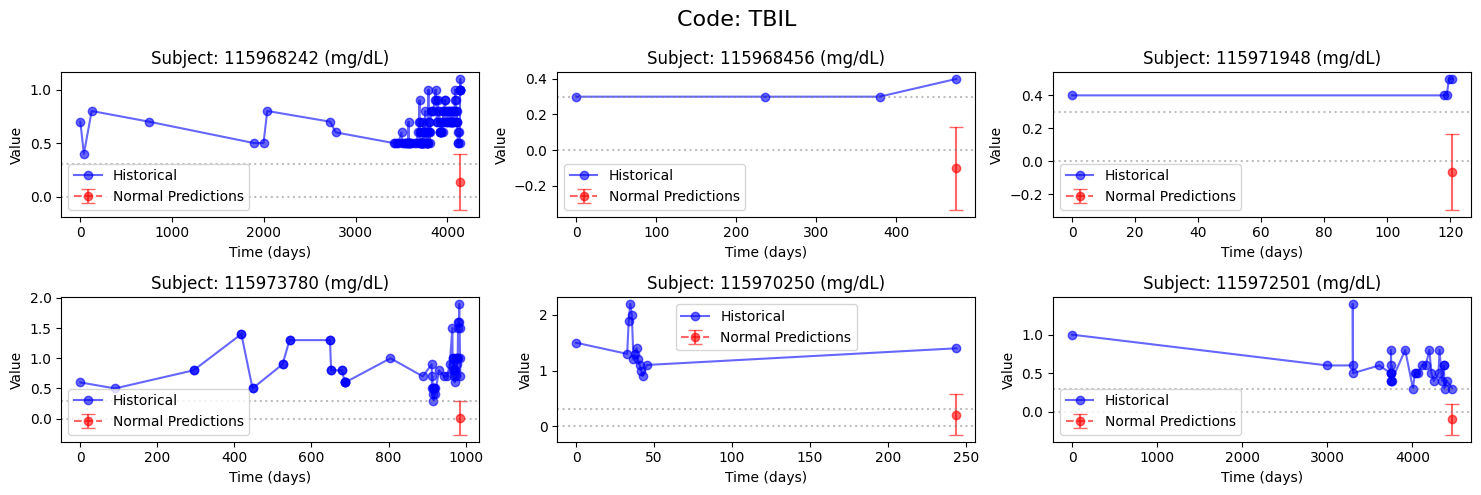

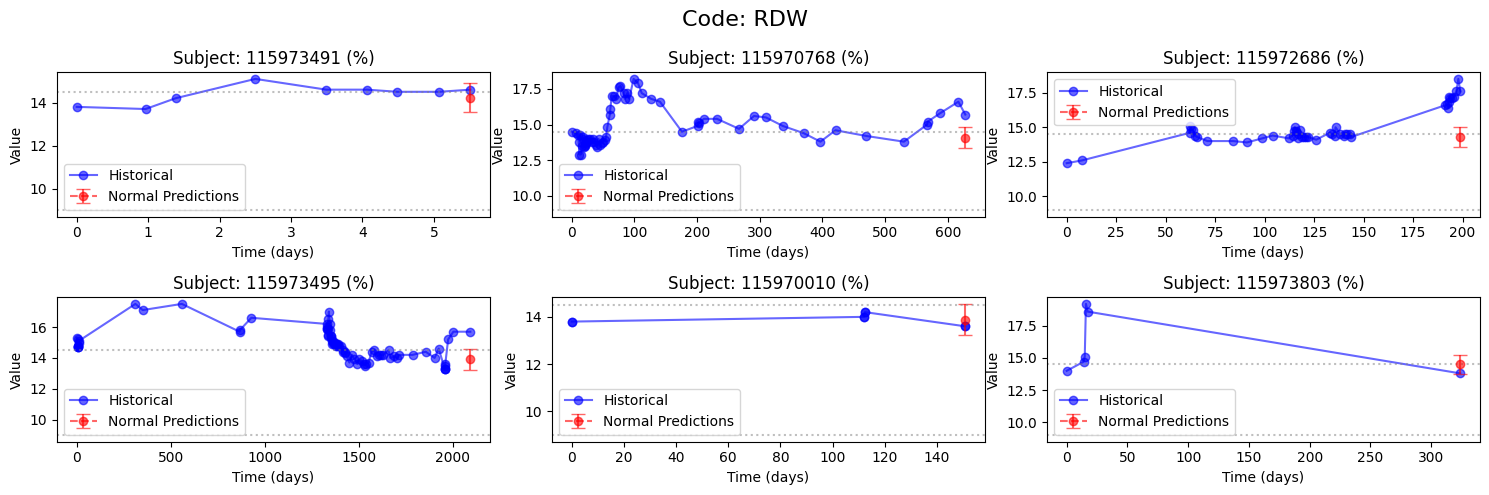

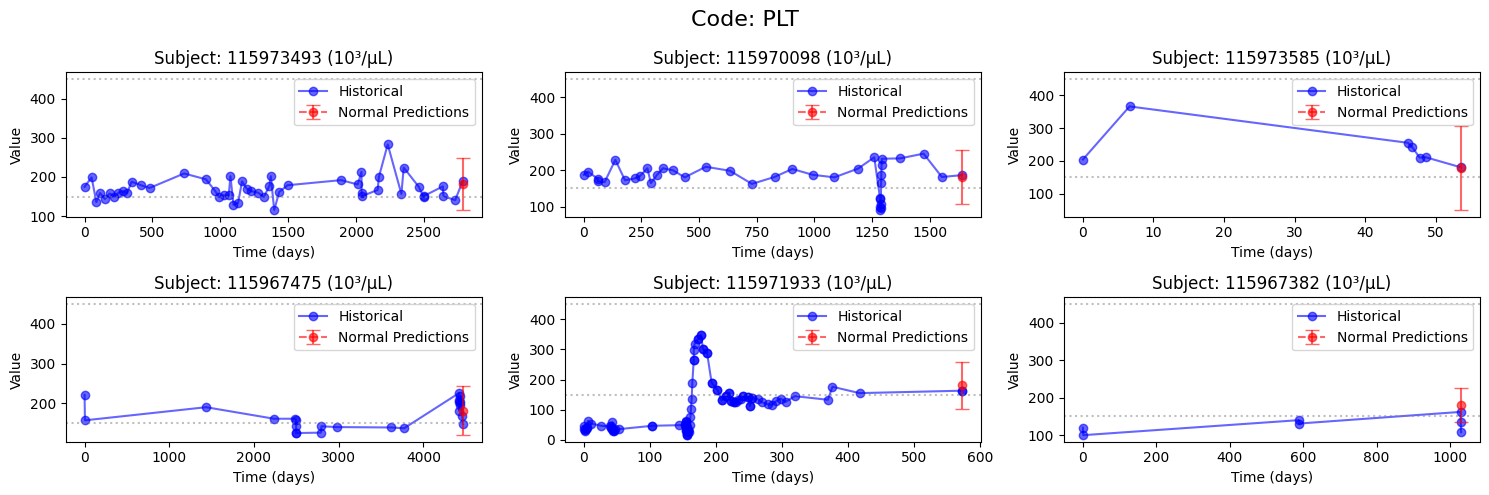

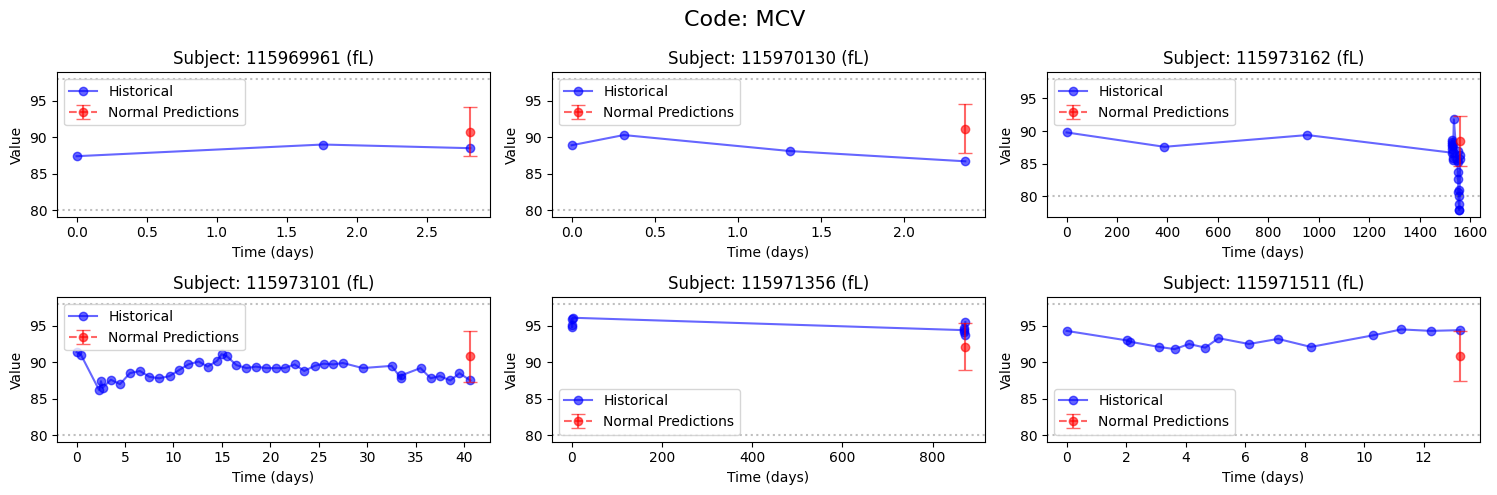

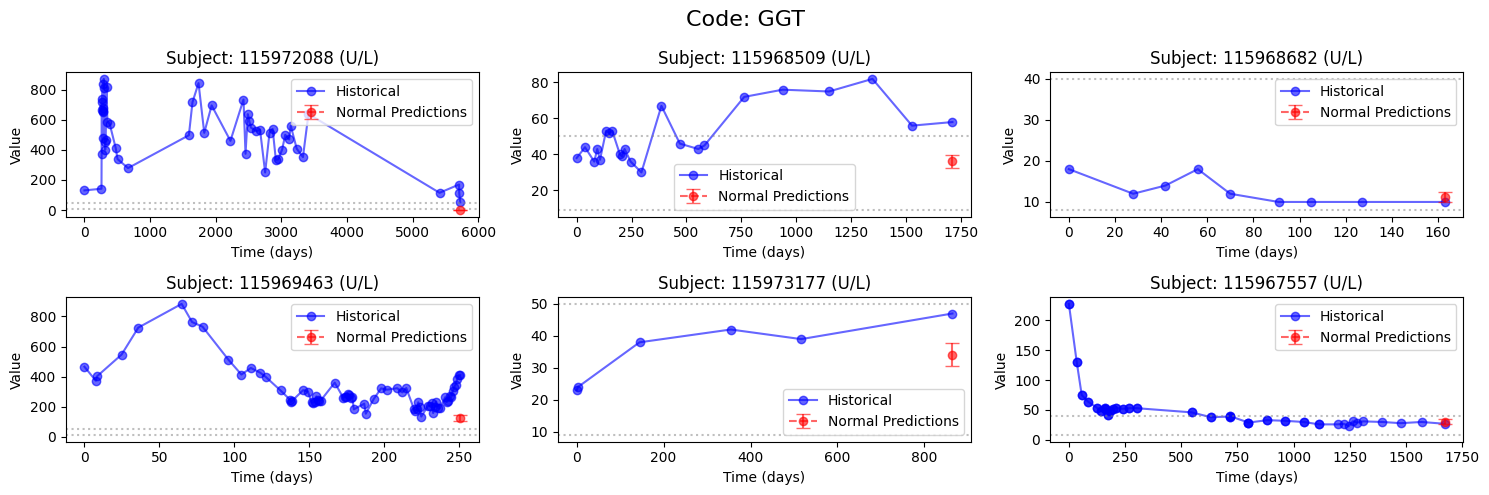

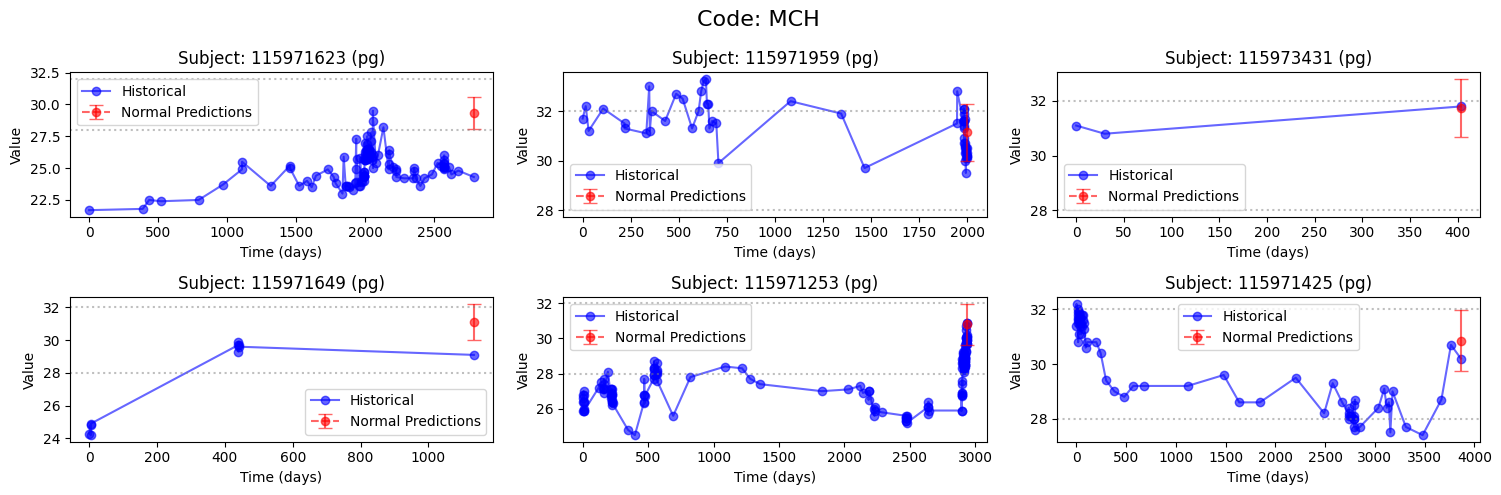

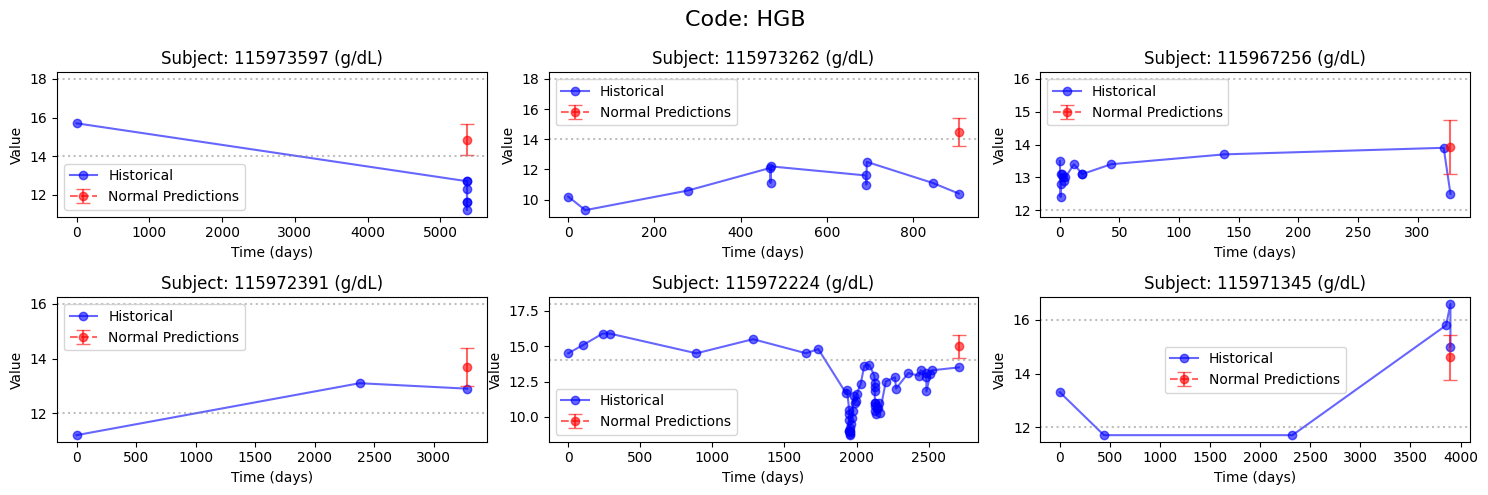

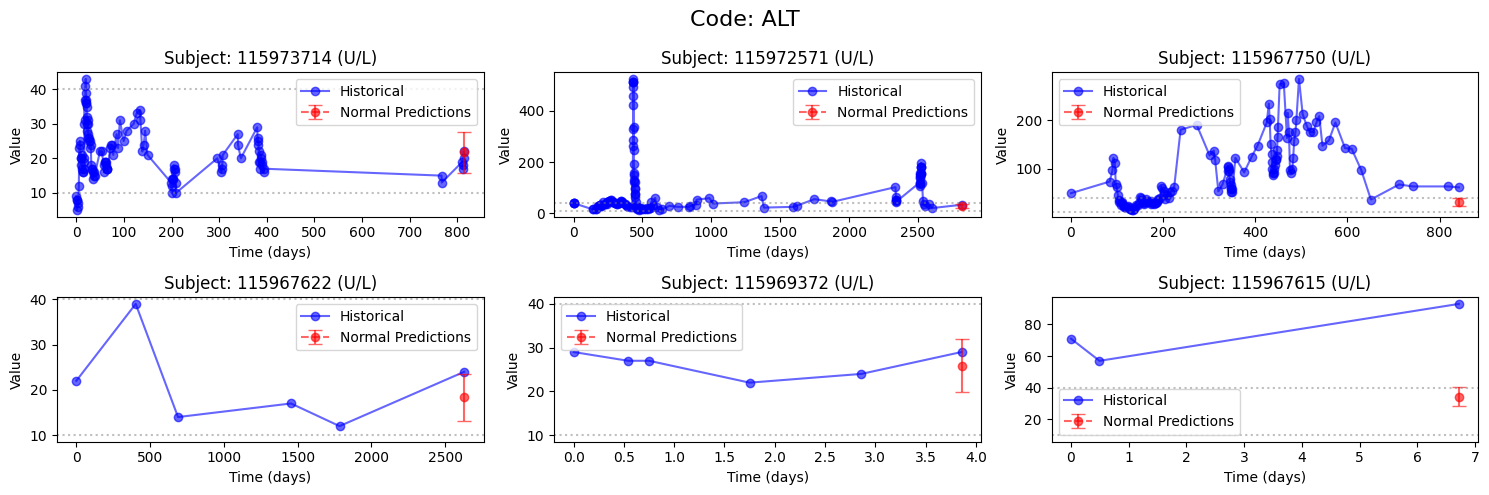

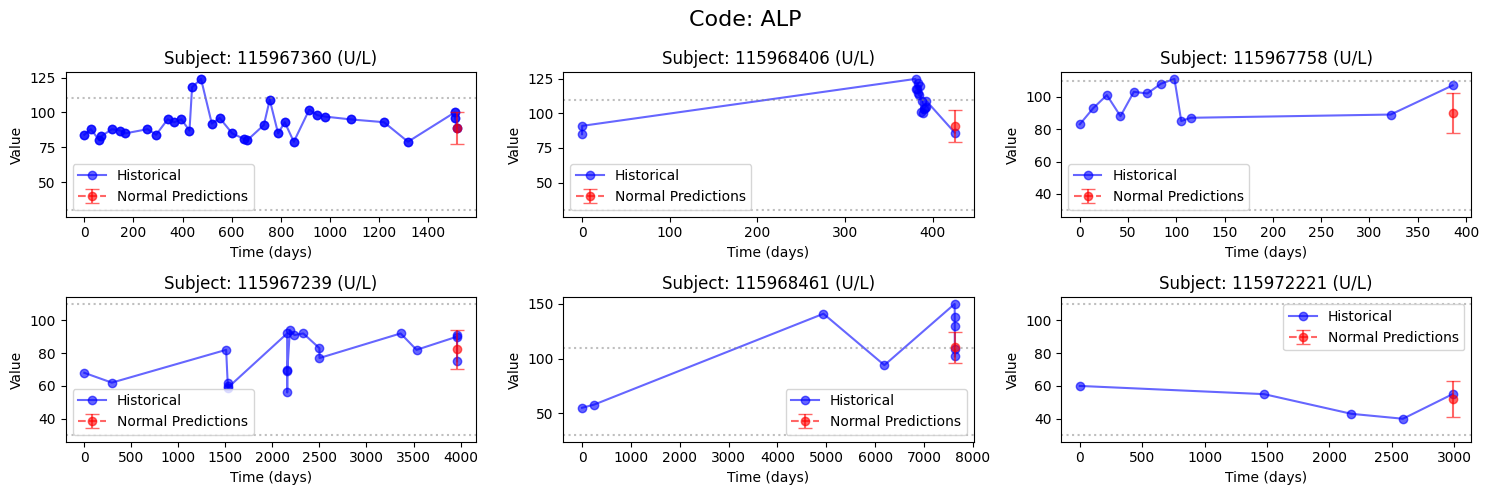

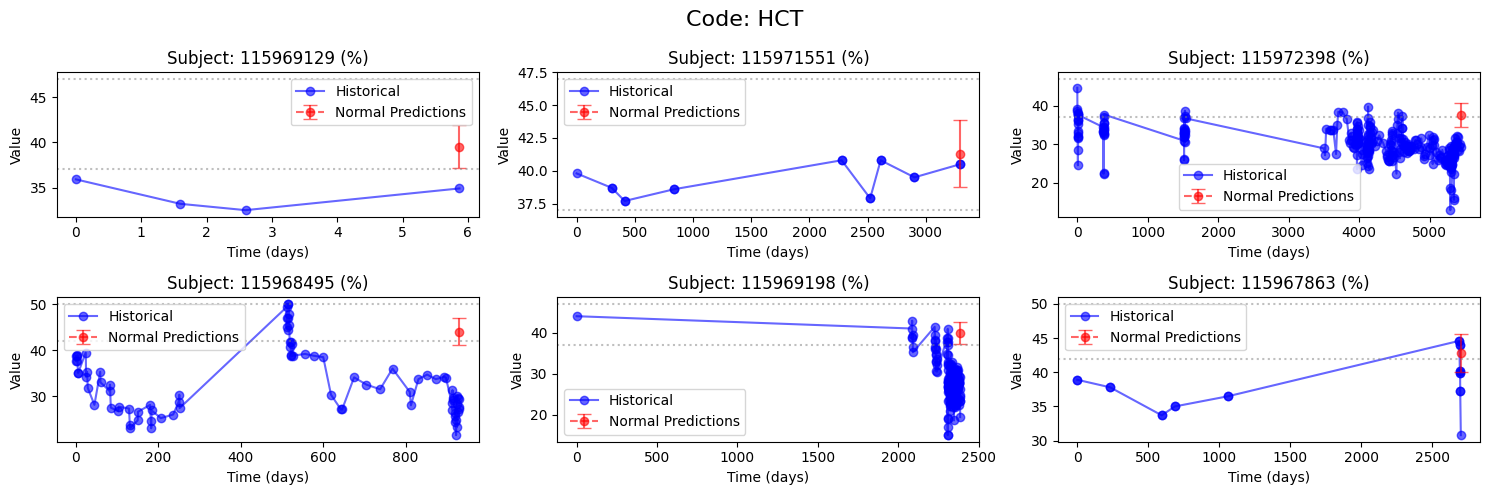

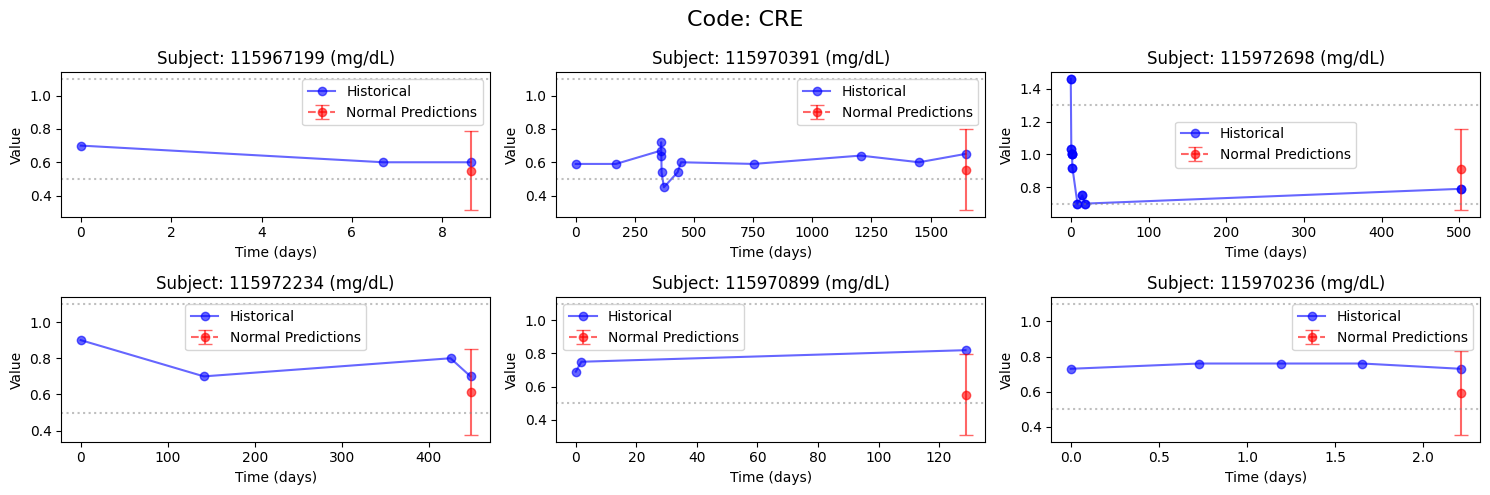

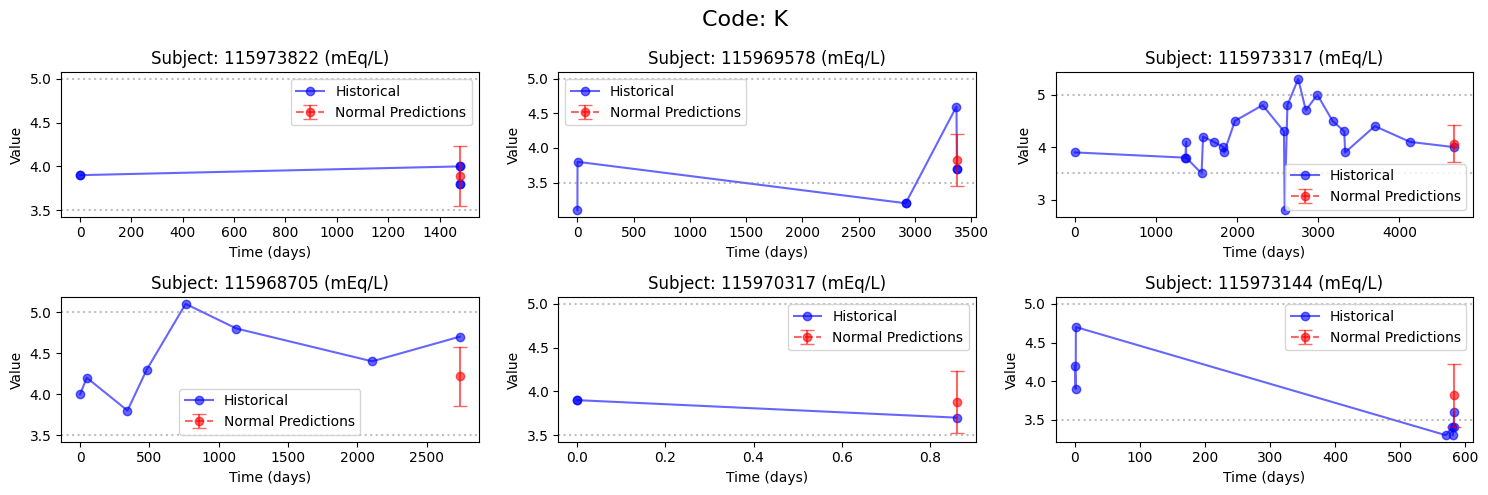

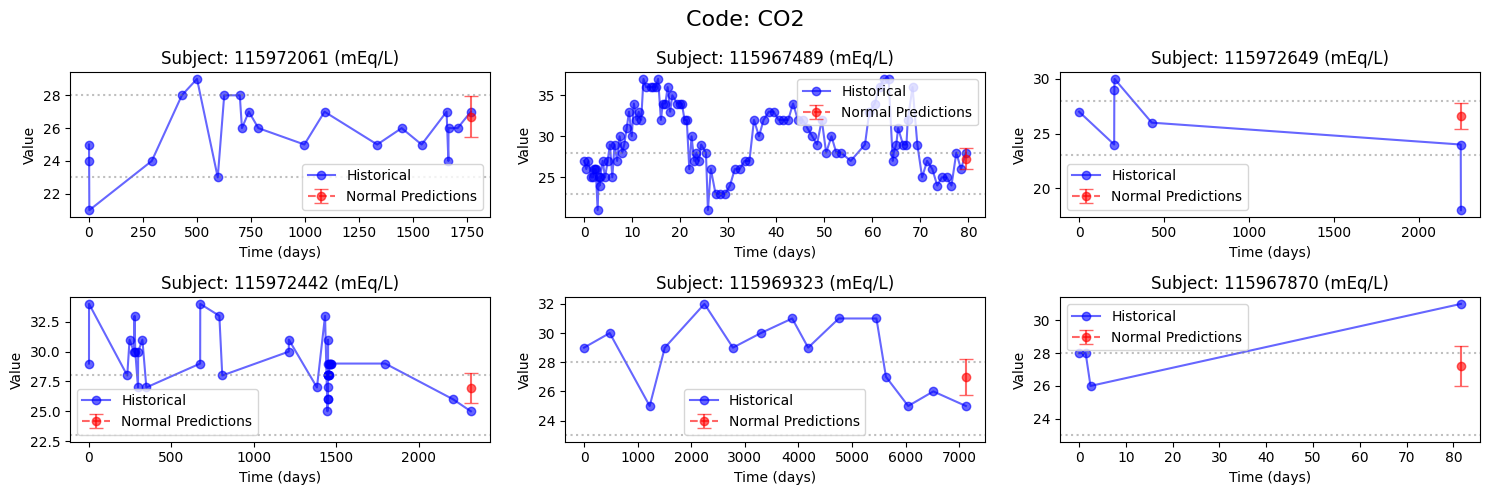

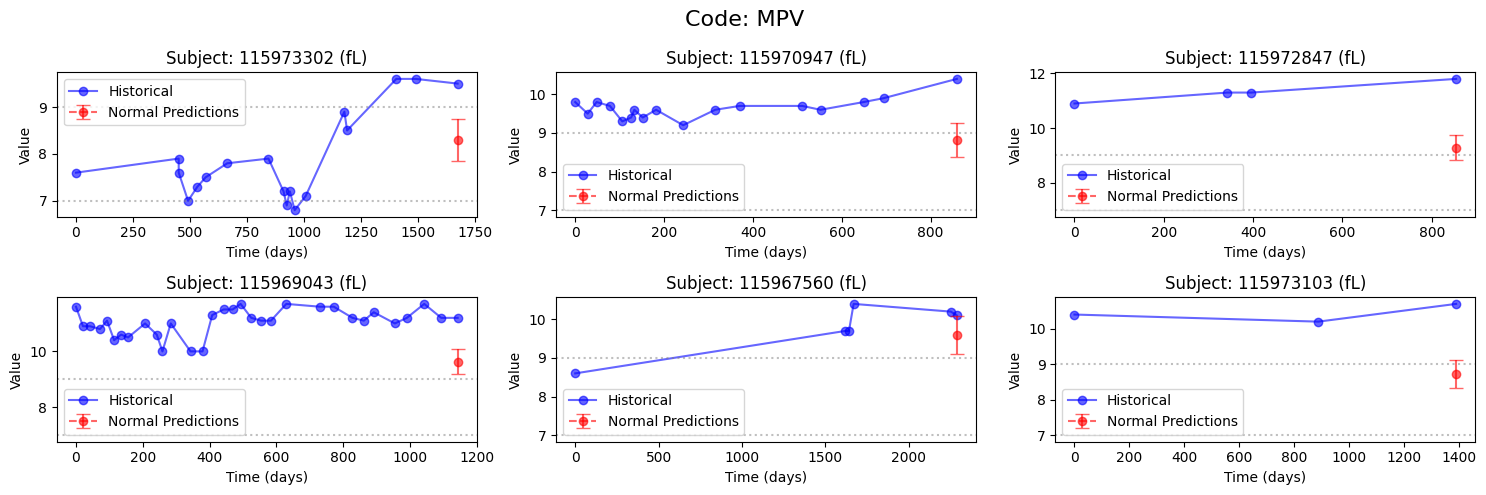

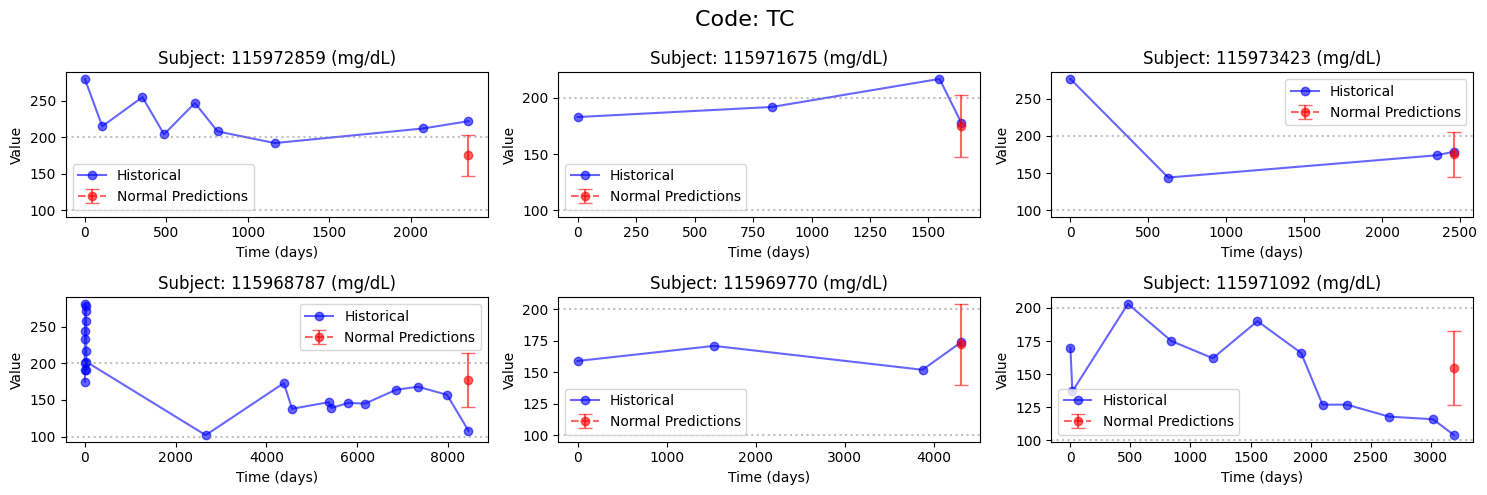

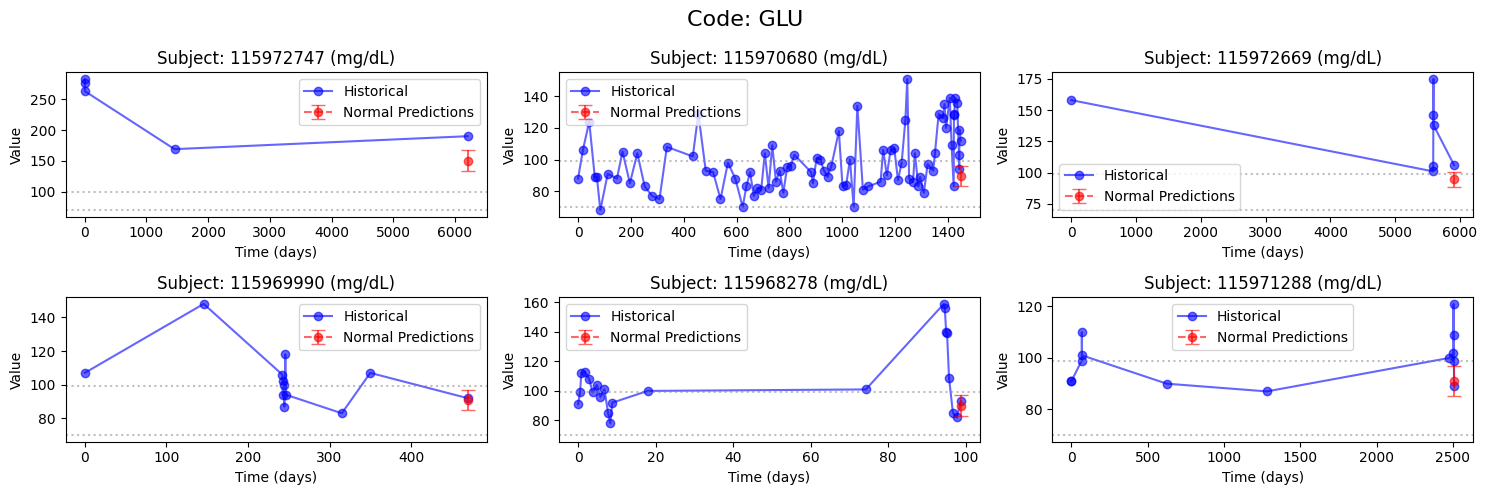

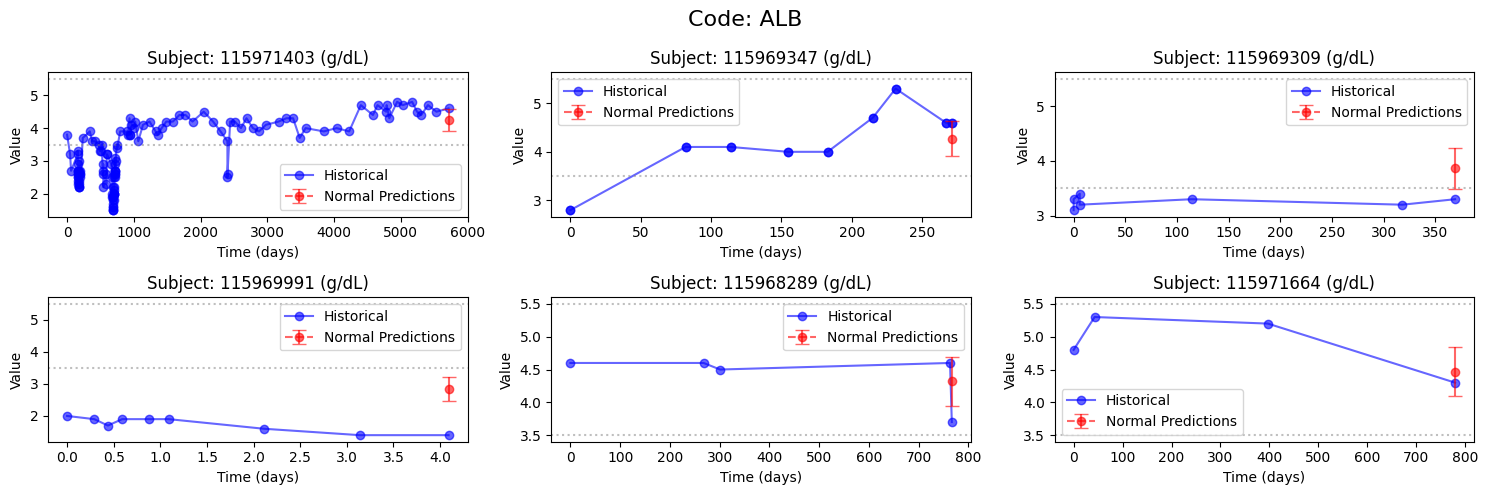

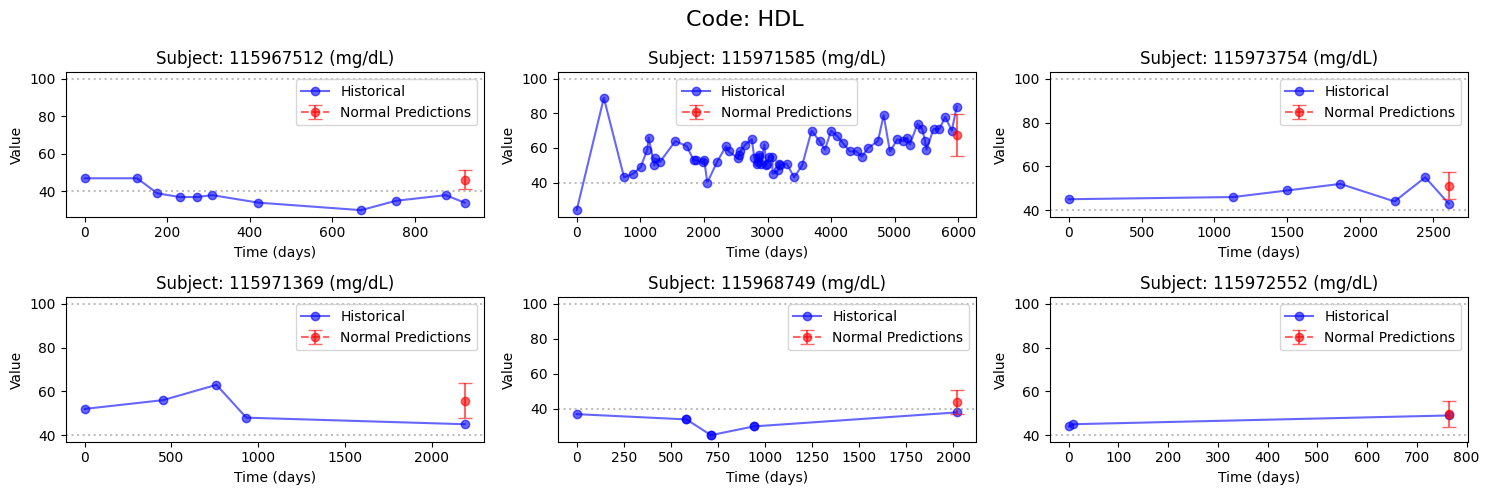

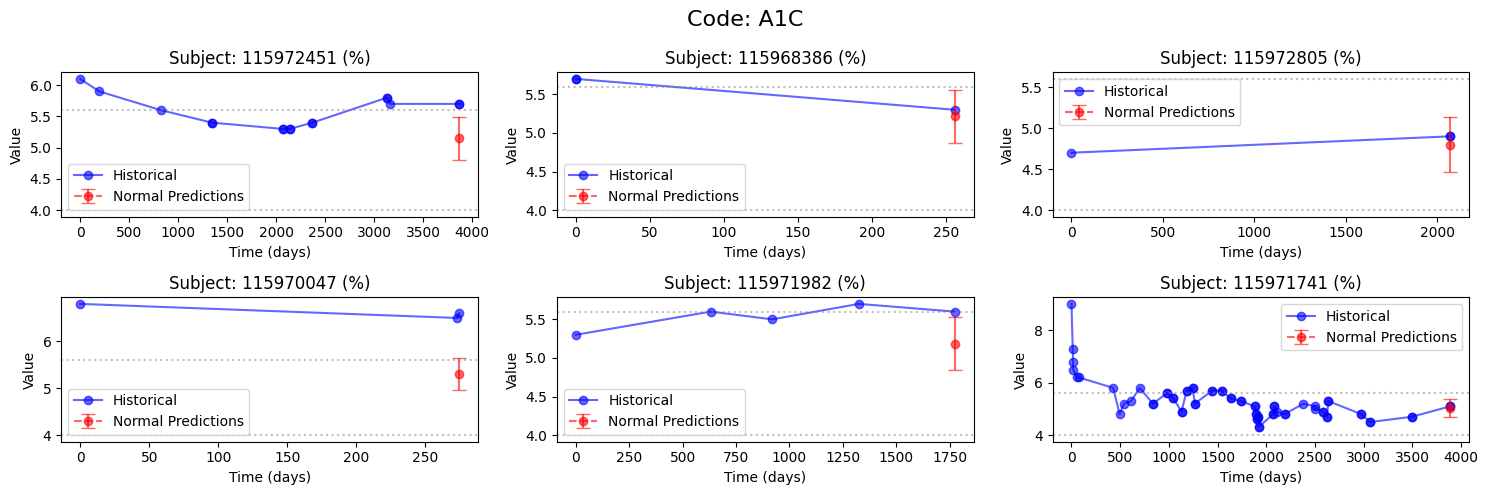

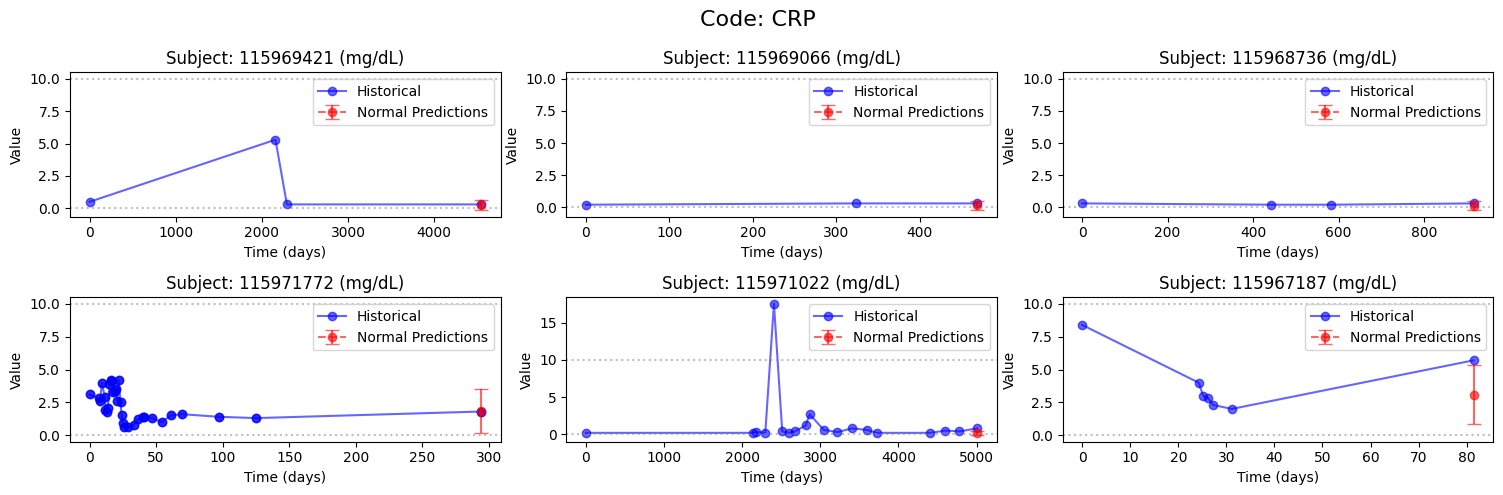

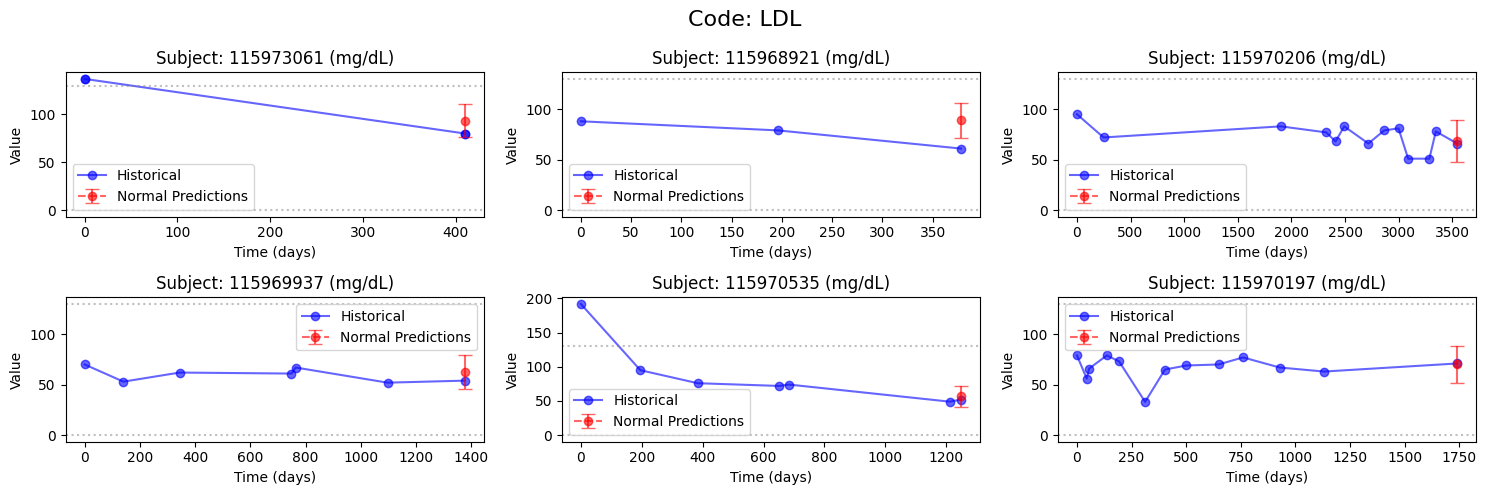

In [104]:
# Plot sequences and predicted normal ranges for each code
for code in unique_codes:
    # Get all sequences for this code
    code_seqs = test_df[test_df['code'] == code]
    
    # Get 6 random subjects for this code
    subject_ids = code_seqs['subject_id'].unique()
    sample_size = min(6, len(subject_ids))
    sample_subjects = np.random.choice(subject_ids, size=sample_size, replace=False)
    
    # Create subplot grid for this code
    fig, axes = plt.subplots(2, 3, figsize=(15, 5))
    fig.suptitle(f'Code: {code}', fontsize=16)
    axes = axes.flatten()
    
    for i, subject_id in enumerate(sample_subjects):
        subject_data = code_seqs[code_seqs['subject_id'] == subject_id]
        ax = axes[i]
        
        # Plot historical sequence
        times = subject_data.iloc[0]['t']
        values = subject_data.iloc[0]['x']
        ax.plot(times, values, 'b-o', alpha=0.6, label='Historical')
        
        normal_preds = subject_data[subject_data['pred_state']=='normal']
        pred_mean = normal_preds['pred_mean'].values[0]
        pred_std = normal_preds['pred_std'].values[0]
        ax.errorbar(times[-1], pred_mean, yerr=pred_std, fmt='r--o', alpha=0.6, label='Normal Predictions', capsize=5)
        # Get reference range
        subject_sex = 'F' if subject_data.iloc[0]['sex'] == 1 else 'M'
        low, high, unit = REFERENCE_INTERVALS[code][subject_sex]
        
        # Add reference range as horizontal lines
        ax.axhline(y=low, color='gray', linestyle=':', alpha=0.5)
        ax.axhline(y=high, color='gray', linestyle=':', alpha=0.5)
        
        ax.set_title(f'Subject: {subject_id} ({unit})')
        ax.set_xlabel('Time (days)')
        ax.set_ylabel('Value')
        ax.legend()
    
    # Remove any empty subplots
    for j in range(sample_size, 6):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()


In [ ]:
# what does the variance depend on 